## Feature Selection and Feature Engineering of Android Bid Request Data from the US

Overview: This notebook uses data exploration and an ExtraTreesClassifier algorithm to determine rank feature importance of a dataset with over 3 millions observations of whether cellphone users clicked an online advertisement between September 2018 and November 2018. This notebook then goes on to reduce the dimensions of the catagorical variables through binning according to click proportion frequency as well as produce new variables from existing features in the dataset. 

In [1]:
# Import python packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from datetime import datetime
import seaborn as sns
%matplotlib inline

In [2]:
# Import dataset
dataset = pd.read_csv('android_bids_us.csv', index_col = 'bidid' )

### Data Exploration 

In [3]:
# View how big the dataset is
dataset.shape

(3148828, 11)

In [4]:
# Quickly see the column names and types of the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3148828 entries, 87b0108c-6e9f-4783-8b80-8dd5aa3529a8 to 971a5f81-96e0-4694-be22-5809e90de06d
Data columns (total 11 columns):
utc_time         int64
app_id           object
user_state       object
user_isp         object
device_maker     object
device_model     object
device_osv       object
device_height    int64
device_width     int64
marketplace      object
click            int64
dtypes: int64(4), object(7)
memory usage: 288.3+ MB


In [5]:
# See what the columns look like
dataset.head()

,utc_time,app_id,user_state,user_isp,device_maker,device_model,device_osv,device_height,device_width,marketplace,click
bidid,,,,,,,,,,,
87b0108c-6e9f-4783-8b80-8dd5aa3529a8,1536444331894,com.OppanaGames.CarSim,TX,AT&T Wireless,NaN,NaN,7.0,720,1280,chartboost,0
9284441f-a6ea-4698-9017-86436b92d416,1536444363932,com.mobilityware.CrownSolitaire,TX,T-Mobile USA,NaN,NaN,7.0,1280,720,chartboost,0
7e4779c2-f757-4324-8c2a-138b558b5a54,1536444386908,com.kuttigames.tenkyurollball,LA,AT&T Wireless,NaN,NaN,7.1.1,720,1280,chartboost,0
b64ea208-38ca-42ac-895e-0842d7352cc3,1536444405023,com.trendactionfree.call_of_sniper_duty_frontl...,TN,Comcast Cable,NaN,NaN,6.0.1,720,1280,chartboost,0
fd0c07cb-31f6-408c-9315-1cb652e76abc,1536444443458,com.landslab.my3rdgrademathgames,NC,AT&T U-verse,NaN,NaN,7.1.1,1024,768,chartboost,0


In [6]:
# Looks like there are some missing values. Inspect the missing values
tot_missdata = dataset.isnull().sum().sort_values(ascending=False)
percent_miss = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
data_type = dataset.dtypes
missing_data = pd.concat([tot_missdata, percent_miss, data_type], axis=1, join = 'inner', keys=['tot_missdata', 'percent_miss', 'data type'])
print(missing_data)

               tot_missdata  percent_miss data type
device_maker         964004      0.306147    object
device_model         963858      0.306101    object
user_isp                 39      0.000012    object
click                     0      0.000000     int64
marketplace               0      0.000000    object
device_width              0      0.000000     int64
device_height             0      0.000000     int64
device_osv                0      0.000000    object
user_state                0      0.000000    object
app_id                    0      0.000000    object
utc_time                  0      0.000000     int64


In [7]:
# Only object columns have missing data so I will just replace with 'missing'
dataset['device_maker'] = dataset['device_maker'].fillna('missing')
dataset['device_model'] = dataset['device_model'].fillna('missing')
dataset['user_isp'] = dataset['user_isp'].fillna('missing')

In [8]:
# Inspect head of dataset one more time
dataset.head()
# It looks like that the missing values were filled in correctly

,utc_time,app_id,user_state,user_isp,device_maker,device_model,device_osv,device_height,device_width,marketplace,click
bidid,,,,,,,,,,,
87b0108c-6e9f-4783-8b80-8dd5aa3529a8,1536444331894,com.OppanaGames.CarSim,TX,AT&T Wireless,missing,missing,7.0,720,1280,chartboost,0
9284441f-a6ea-4698-9017-86436b92d416,1536444363932,com.mobilityware.CrownSolitaire,TX,T-Mobile USA,missing,missing,7.0,1280,720,chartboost,0
7e4779c2-f757-4324-8c2a-138b558b5a54,1536444386908,com.kuttigames.tenkyurollball,LA,AT&T Wireless,missing,missing,7.1.1,720,1280,chartboost,0
b64ea208-38ca-42ac-895e-0842d7352cc3,1536444405023,com.trendactionfree.call_of_sniper_duty_frontl...,TN,Comcast Cable,missing,missing,6.0.1,720,1280,chartboost,0
fd0c07cb-31f6-408c-9315-1cb652e76abc,1536444443458,com.landslab.my3rdgrademathgames,NC,AT&T U-verse,missing,missing,7.1.1,1024,768,chartboost,0


In [9]:
# look at the proportions of clicks to no clicks in the dataset 
dataset['click'].value_counts()

0    2935629
1     213199
Name: click, dtype: int64

In [10]:
dataset['click'].value_counts(normalize=True)
# It looks like substantially more non clicks than click. From this I would expect a model to produce more non click than clicks

0    0.932293
1    0.067707
Name: click, dtype: float64

In [11]:
# Inspect continuous variables 'device_width' and 'device_height'
dataset.groupby('click').median()
# Device_width has the same median for clicks and non_clicks. This might imply that device_width not not make a significant difference in whether
# users click the add or not
# Median of device_height is slightly higher for clicks than non clicks this variable might be more important than device_width for predicting clicks

,utc_time,device_height,device_width
click,,,
0,1538454579744,1080,1080
1,1538604468218,1280,1080


In [12]:
dataset.groupby('click').mean()

,utc_time,device_height,device_width
click,,,
0,1.538318e+12,1177.314715,1158.549623
1,1.538555e+12,1231.303003,1062.963874


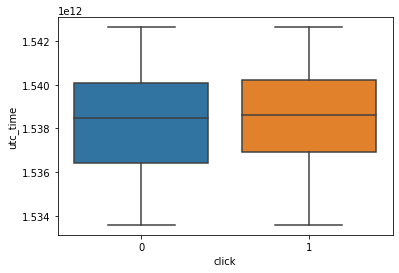

In [16]:
# Compare clicks against time variable - utc_time
sns.boxplot(x=dataset['click'], y=dataset['utc_time'], data = dataset)
# Both median and mean, 1st and 3rd quartiles are at later points in time  for clicks than non clicks. As well the overall bulk of the distribution of
# the utc_time variable given the user clicked is at a later point in time than the no utc_time variable given no clicks.

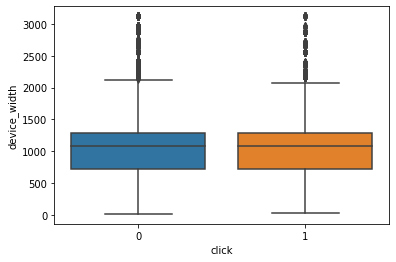

In [17]:
# Inspect the box plots of both the size variables
sns.boxplot(x=dataset['click'], y=dataset['device_width'], data = dataset)
# On a quick visual inspection distributions of the device_width for click and non clicks look very similiar

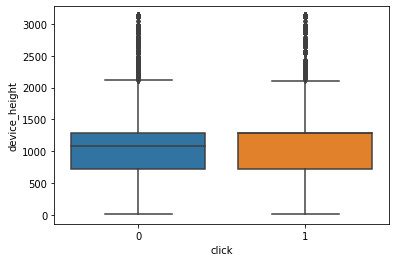

In [18]:
sns.boxplot(x=dataset['click'], y=dataset['device_height'], data = dataset)
# device_height based on clicks and non clicks looks slightly different around the 2nd quartile
# However the 1st and 3rd as well as the potential outliers are very similiar
# It is predicted that device_height is a more important variable thandevice width

Inspecting catagorical variables

In [19]:
# Quick look at distributions of the object data
pd.DataFrame(dataset.describe(include=['object', 'bool']))

,app_id,user_state,user_isp,device_maker,device_model,device_osv,marketplace
count,3148828,3148828,3148828,3148828,3148828,3148828,3148828
unique,14869,51,3450,266,2343,20,1
top,com.banananadco.blackjack,TX,T-Mobile USA,missing,missing,7.0,chartboost
freq,54134,409365,737204,964004,963858,1083916,3148828


From this I can see that there a lot of unique values espcially in app_id, user_isp, device_model.

Marketplace is worth noting as it only contains one catagory for every observation - won't affect the model

Device_maker and device_model both have a missing value as their most common catagory. This will be kept and can become its own catagory in OneHotEncoding. Imputing using an observed most common value might cause too much bias in the data

In [3]:
# Function to determine and visualize the proportion of clicks each catagory in each variable is responsible for 
def clickproportion(variable: str):
    w = pd.crosstab(dataset[variable], dataset['click'])
    z = (w[1]/len(dataset[dataset['click'] == True])).sort_values(ascending=False)
    z = z.iloc[:15,]
    plt.figure(figsize=(10,5))
    chart = sns.barplot(z.index, z, alpha=0.9)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    return z 

In [5]:
# Function to get an idea of distribution of each catagorical variable
def distribution(variable: str):
    x = pd.DataFrame(dataset[variable].value_counts()).sort_values(by = variable, ascending=False)  
    y = x.iloc[:15,]
    plt.figure(figsize=(10,5))
    chart = sns.barplot(y.index, y[variable], alpha=0.9)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    return y
   

,app_id
com.banananadco.blackjack,54134
com.kiloo.subwaysurf,53670
toy.blast.pop.cubes.puzzle,49726
com.blackcircleapps.halloweenbingo,49273
com.mobilityware.spider,44715
com.mobilityware.CrownSolitaire,44357
com.mobilityware.freecell,41566
com.RocketGames.ClassicSlots,39294
com.thumbspire.weedfirm2,34012
com.spacegame.basic3,28483


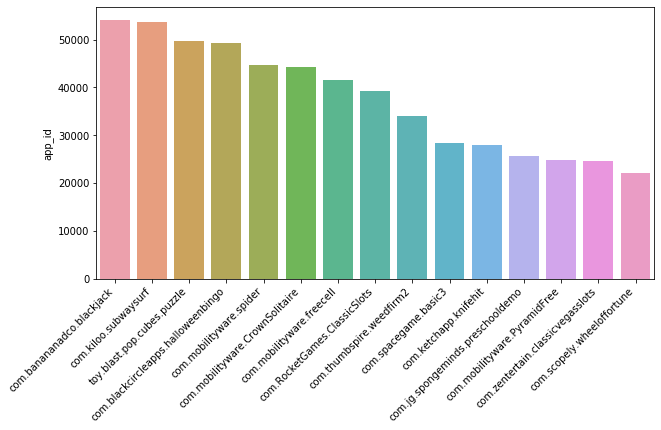

In [6]:
# Distribution of app_id
distribution('app_id')

app_id
com.banananadco.blackjack                              0.026590
com.jg.spongeminds.preschooldemo                       0.021327
com.thumbspire.weedfirm2                               0.019883
com.ketchapp.knifehit                                  0.019221
toy.blast.pop.cubes.puzzle                             0.016632
com.kiloo.subwaysurf                                   0.015896
air.com.sublinet.tastytale                             0.015155
com.gia.iloveftd                                       0.011501
com.RocketGames.ClassicSlots                           0.010202
com.RenownEntertainment.BallHopAE                      0.009311
com.spacegame.basic3                                   0.008297
com.mss.doublediamond                                  0.007378
com.blackcircleapps.halloweenbingo                     0.006623
com.avarmmg.net.drawandspin                            0.006215
com.pixelbytesplay.pregnant.mom.and.baby.precaution    0.006201
Name: 1, dtype: float64

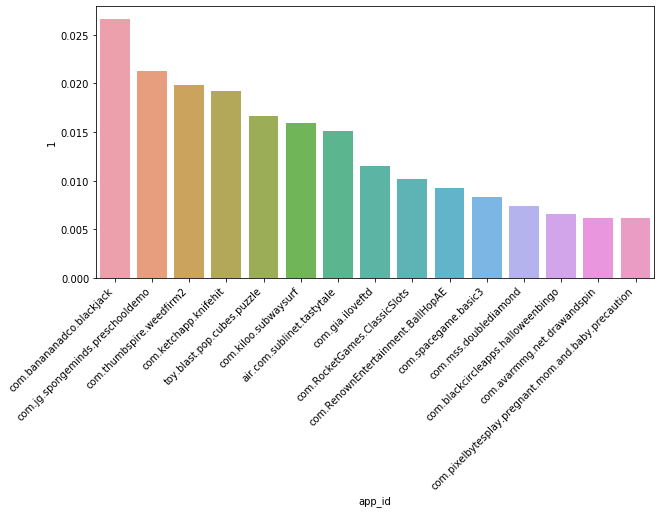

In [4]:
# Proportion of clicks for with app_id
clickproportion('app_id')


,user_state
TX,409365
CA,394602
FL,263207
IL,194379
NY,180546
GA,127141
MI,120948
NC,120590
OH,102463
PA,90165


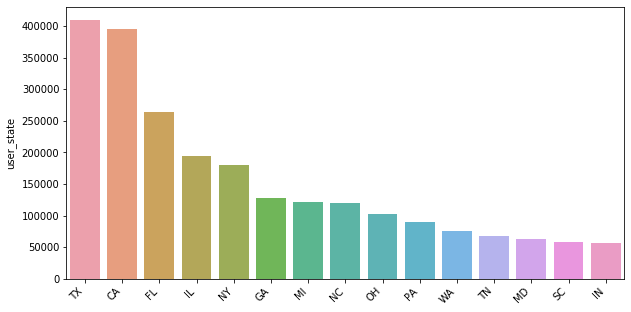

In [7]:
distribution('user_state')

user_state
CA    0.129677
TX    0.127566
FL    0.085033
IL    0.059949
NY    0.058870
GA    0.040704
MI    0.039011
NC    0.038495
OH    0.032298
PA    0.028466
WA    0.023429
TN    0.021768
MD    0.020600
SC    0.018832
AZ    0.018110
Name: 1, dtype: float64

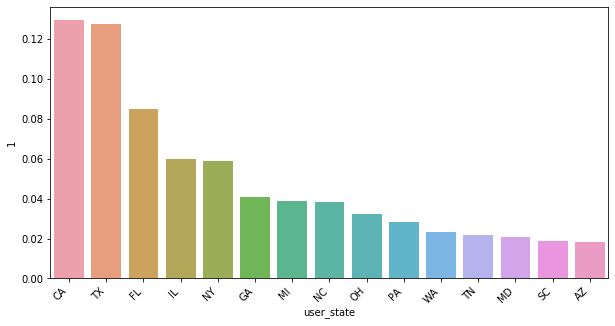

In [8]:
# proportion of 'user_state'
clickproportion('user_state')


,user_isp
T-Mobile USA,737204
Spectrum,382182
Comcast Cable,342711
AT&T Wireless,330291
Sprint PCS,265010
Verizon Wireless,263017
AT&T U-verse,185588
Cox Communications,77582
CenturyLink,73506
Verizon Fios,47010


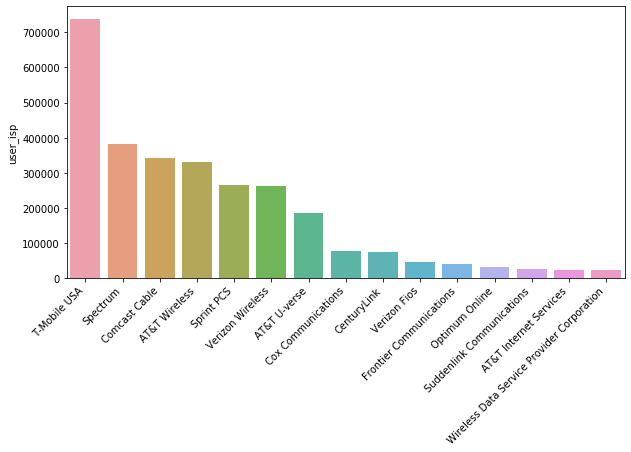

In [9]:
distribution('user_isp')

user_isp
T-Mobile USA                 0.236952
Spectrum                     0.133772
Comcast Cable                0.123002
AT&T Wireless                0.090737
Sprint PCS                   0.078326
Verizon Wireless             0.073893
AT&T U-verse                 0.063893
Cox Communications           0.027256
CenturyLink                  0.023494
Verizon Fios                 0.016257
Frontier Communications      0.012880
Optimum Online               0.011398
Suddenlink Communications    0.008387
AT&T Internet Services       0.007627
Windstream Communications    0.006285
Name: 1, dtype: float64

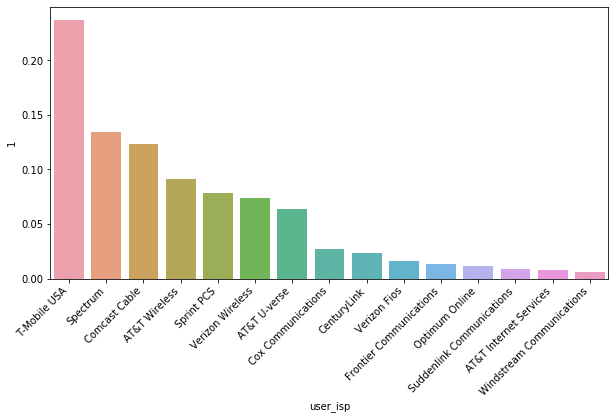

In [10]:
clickproportion('user_isp')


,device_maker
Samsung,863542
LG,657259
Motorola,224631
ZTE,186605
ALCATEL,55049
HTC,27495
Google,24529
T-Mobile,21506
Coolpad,18374
ALCATEL ONE TOUCH,17426


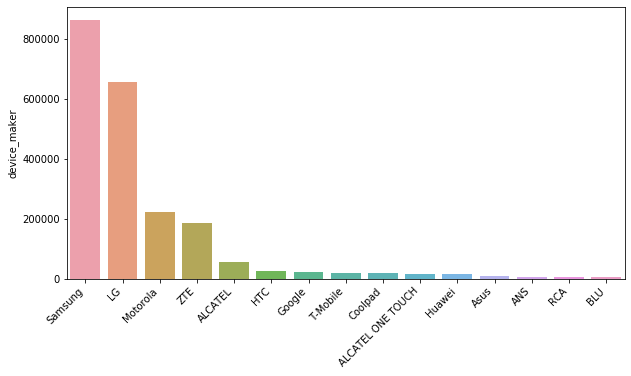

In [11]:
distribution('device_maker')

device_maker
LG                   0.266061
Samsung              0.238191
Motorola             0.088720
ZTE                  0.045089
ALCATEL              0.018157
Google               0.010647
ALCATEL ONE TOUCH    0.008175
HTC                  0.008161
T-Mobile             0.007631
Huawei               0.006735
Asus                 0.004747
ANS                  0.004409
RCA                  0.004071
Coolpad              0.004006
Verizon              0.003978
Name: 1, dtype: float64

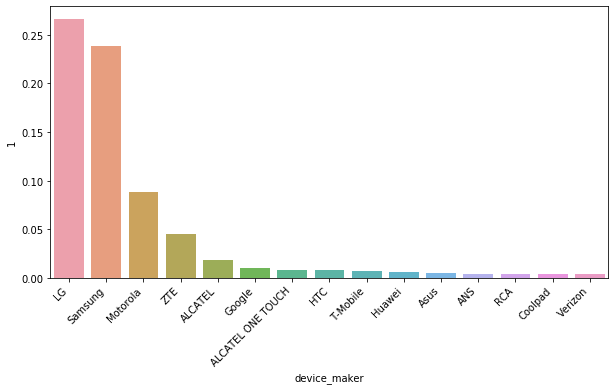

In [12]:
clickproportion('device_maker')


,device_model
LM-X210(G),110596
SM-J327T1,103704
Moto E4,88164
MP260,78291
MS210,45640
SM-G955U,39648
SM-G950U,33207
SP200,32685
Z982,28085
LS777,27577


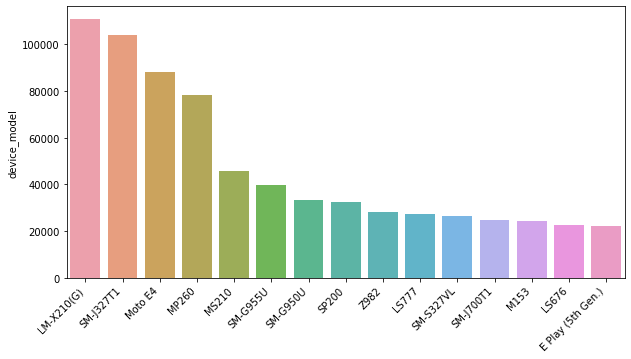

In [13]:
distribution('device_model')

device_model
LM-X210(G)           0.040441
Moto E4              0.039850
MP260                0.035586
SM-J327T1            0.027294
MS210                0.021084
SM-G955U             0.012073
LS777                0.011562
SP200                0.011004
M153                 0.009859
LS676                0.009189
MP450                0.008912
E Play (5th Gen.)    0.008241
SM-G950U             0.007716
Z982                 0.007458
SM-S327VL            0.007336
Name: 1, dtype: float64

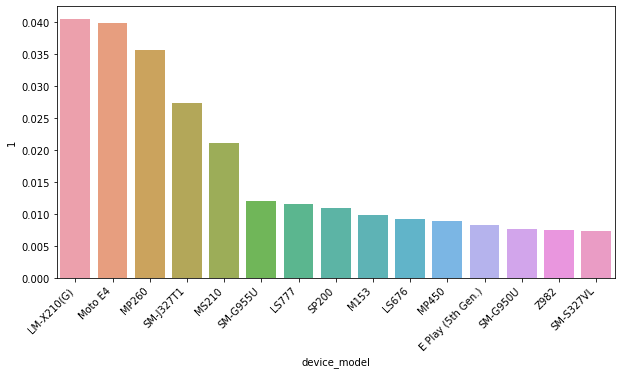

In [14]:
clickproportion('device_model')


,device_osv
7.0,1083916
8.0.0,596679
7.1.1,557710
6.0.1,535421
7.1.2,201139
8.1.0,88852
6.0,64873
9,20121
7.1,59
P,20


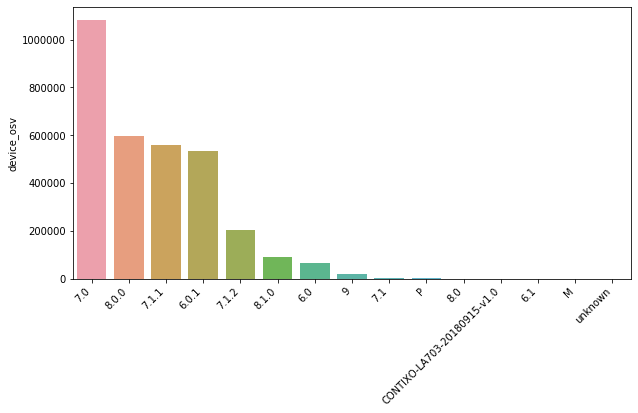

In [15]:
distribution('device_osv')

device_osv
7.0                            0.373243
7.1.1                          0.183711
6.0.1                          0.161656
8.0.0                          0.146070
7.1.2                          0.072486
6.0                            0.027983
8.1.0                          0.026914
9                              0.007880
P                              0.000023
7.1                            0.000023
M                              0.000005
CONTIXO-LA703-20180915-v1.0    0.000005
5.0 by mrkindaiji              0.000000
6.1                            0.000000
unknown                        0.000000
Name: 1, dtype: float64

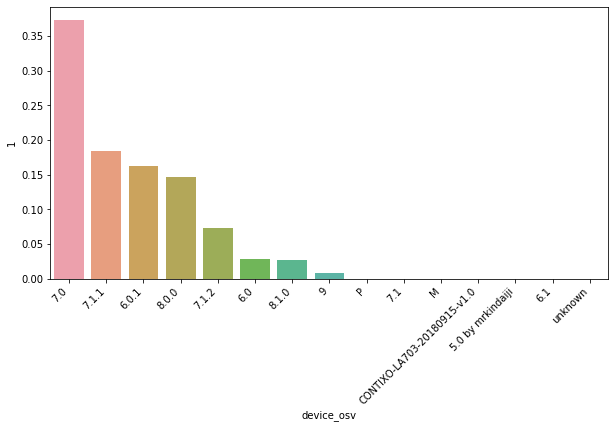

In [16]:
clickproportion('device_osv')

From the looking at the distributions and the proportions each catogory in each variable is responsible for, there does not appear to be catagories
that increase the number of clicks. For all these catagories increases
in the percentage of the number of clicks is proportional to fraction of the dataset each catagory takes up. It is predicted that the most important features are those that are responsible for large proportions of clicks such as Texas and Calfornia from user_state and T-Mobile USA from user_isp.

An ExtraTrees Classifier will be used to determine variable importance

In [34]:
# Given the size of the dataset without reducing catagorical variables in order for OneHotEncoder to work the dataset needs to be reduced

# Keep .2% of most recent fraction of the dataset
x = len(dataset.index) - int(round(len(dataset.index)*.002,0))
X = dataset.iloc[x:, :-1]  #independent columns
y = dataset.iloc[x:,-1]

In [35]:
# Encode catogirical data using OneHotEncoder
obj_data = (dataset.dtypes == 'object')
object_cols = list(obj_data[obj_data].index)
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_encoder.fit(X[object_cols])
x_cat = OH_encoder.transform(X[object_cols])

x_cat = pd.DataFrame(x_cat)
x_cat.columns = OH_encoder.get_feature_names()
x_cat.index = X.index
X = X.drop(object_cols, axis=1)
X = pd.concat([X, x_cat], axis=1)

In [38]:
# Use ExtraTrees Classifier to determine most important features
regressor = ExtraTreesClassifier()
regressor.fit(X,y)
fe = regressor.feature_importances_
feat_importances = pd.Series(regressor.feature_importances_, index=X.columns).sort_values(ascending=False)


In [39]:
# Displaying top 15 most important variables
feat_importances.head(20)

utc_time               0.192487
device_height          0.031507
device_width           0.029660
x5_7.0                 0.012396
x2_T-Mobile USA        0.012225
x1_TX                  0.011027
x2_Spectrum            0.010127
x2_Comcast Cable       0.009700
x1_CA                  0.009494
x1_FL                  0.009240
x5_6.0.1               0.008674
x5_7.1.1               0.008259
x2_AT&T Wireless       0.007487
x5_8.0.0               0.007431
x1_IL                  0.007293
x2_Sprint PCS          0.007187
x2_Verizon Wireless    0.007076
x2_AT&T U-verse        0.006884
x1_NY                  0.006046
x1_MI                  0.005516
dtype: float64

In [40]:
# Displaying top 15 least important variables
feat_importances.tail(15)

x4_SM-N920C                                                  2.772102e-09
x2_Boston University                                         4.530148e-10
x2_Sierra Tel Internet                                       0.000000e+00
x0_com.fun.crazy.chinese.food.cafe                           0.000000e+00
x2_Secom                                                     0.000000e+00
x0_com.Mobogames.WarSpirit                                   0.000000e+00
x0_com.fag.cage.revolution.wrestling.world.wrestling.game    0.000000e+00
x4_SM-A720F                                                  0.000000e+00
x0_com.bitflash.gems.story                                   0.000000e+00
x0_com.appymint.safepuzzles                                  0.000000e+00
x0_com.givefivegames.kidspuzzles                             0.000000e+00
x4_SM-J710F                                                  0.000000e+00
x2_CC Communications                                         0.000000e+00
x0_com.dfz.car.factory.maker.mechanic.

Keys for x0 to x6:
- x0 - app_id 
- x1 - user_state 
- x2 - user_isp
- x3 - device_maker
- x4 - device_model
- x5 - device_osv
- x6 - marketplace

Discussion:
1. Marketplace has zero importance because it is a constant. 
2. Catagories is each variable that have high frequency and happen to also to contain large fractions of the user clicks are ranked as important. Examples include 7.0 from device_osv and T-mobile USA from user_isp.
3. Device_width is ranked more important than device_height as predicted, however they both rank higher than all the catagorical variables.This is not surprising since device_width and device_height are entire catgories which span across all observations while each catagory under x0 to x6 span at most across 30% of the observations.
4. utc_time variable is most important. Boxplots and median suggested that later times in series involved more clicks - there could be seasonal effects in clicks.
5. Top 20 most important catagorical variable only contain catagories from user_state, user_isp and device_osv. It is surprising that catagories from device_model and device_maker with proportions of clicks up to 30% did not make the top 20 list.

## 2. Feature Engineering

#### Reduce dimensions of catagorical variables

In [41]:
# Function that finds top 4 catagories with the highest proportion of clicks and then replaces all other catagories in that variable as "other"
# This function reduces number of catagories in each variable
def relabeler(variable: str):
    w = pd.crosstab(dataset[variable], dataset['click'])
    z = (w[1]/len(dataset[dataset['click'] == True])).sort_values(ascending=False)
    choices = list(z.index)[:4]
    conditions = []
    for i in choices:
        x = dataset[variable] == i
        conditions.append(x)
    dataset[variable] = np.select(conditions, choices, default='Else')

In [42]:
# Re-catagorize the existing catagorigal variables to make it so they each have a maximum of 5 catagories using relabeler

#First remove marketplace from the list of object columns
obj_data = (dataset.dtypes == 'object')
object_cols = list(obj_data[obj_data].index)
object_cols.remove('marketplace')

# Use relabeler to reduce number of catagories
for i in object_cols:
    relabeler(i)

In [43]:
# Remove marketplace column
dataset = dataset.drop(['marketplace'], axis=1)

In [44]:
# Inspect new catagories
pd.DataFrame(dataset.describe(include=['object', 'bool']))

,app_id,user_state,user_isp,device_maker,device_model,device_osv
count,3148828,3148828,3148828,3148828,3148828,3148828
unique,5,5,5,5,5,5
top,Else,Else,Else,missing,Else,7.0
freq,3006958,1887275,1356440,964004,1907919,1083916


#### Working with utc_time data

In [45]:
# Extract the day of the week and the month from utc_time
x= datetime.fromtimestamp(float(str(dataset.iloc[0,0])[0:10]))
dataset['utc_time'] = dataset['utc_time'].apply(lambda x:datetime.fromtimestamp(float(str(x)[0:10])))
dataset['month'] = dataset['utc_time'].apply(lambda x: x.strftime("%B"))
dataset['day'] = dataset['utc_time'].apply(lambda x: x.strftime("%A"))

In [46]:
dataset.head()

,utc_time,app_id,user_state,user_isp,device_maker,device_model,device_osv,device_height,device_width,click,month,day
bidid,,,,,,,,,,,,
87b0108c-6e9f-4783-8b80-8dd5aa3529a8,2018-09-09 01:05:31,Else,TX,AT&T Wireless,missing,missing,7.0,720,1280,0,September,Sunday
9284441f-a6ea-4698-9017-86436b92d416,2018-09-09 01:06:03,Else,TX,T-Mobile USA,missing,missing,7.0,1280,720,0,September,Sunday
7e4779c2-f757-4324-8c2a-138b558b5a54,2018-09-09 01:06:26,Else,Else,AT&T Wireless,missing,missing,7.1.1,720,1280,0,September,Sunday
b64ea208-38ca-42ac-895e-0842d7352cc3,2018-09-09 01:06:45,Else,Else,Comcast Cable,missing,missing,6.0.1,720,1280,0,September,Sunday
fd0c07cb-31f6-408c-9315-1cb652e76abc,2018-09-09 01:07:23,Else,Else,Else,missing,missing,7.1.1,1024,768,0,September,Sunday


In [47]:
dataset = dataset.drop(['utc_time'], axis=1)

## Part 3: Making predictions

This section of the notebook describes using a Random Forest Classifier to predict if users click the online advertisement or not.


In [53]:
# Using the entire dataset in infeasible on my computer so I will cut down the dataset by 90% so I can run my model
dataset = pd.read_csv('android_bids_us.csv', index_col = 'bidid')
dataset = dataset.sample(frac = 0.1) # note running models with more data does not improve results

In [54]:
obj_data = (dataset.dtypes == 'object')
object_cols = list(obj_data[obj_data].index)
dataset[object_cols] = dataset[object_cols].fillna('missing')

In [55]:
X = dataset.iloc[:, :-1]  
y = dataset.iloc[:,-1] 

In [56]:
def relabeler(variable: str):
    w = pd.crosstab(X[variable], dataset['click'])
    z = (w[1]/len(X[dataset['click'] == True])).sort_values(ascending=False)
    choices = list(z.index)[:4]
    conditions = []
    for i in choices:
        x = X[variable] == i
        conditions.append(x)
    X[variable] = np.select(conditions, choices, default='Else')
    
object_cols.remove('marketplace')

In [57]:
for i in object_cols:
    relabeler(i)

In [58]:
pd.DataFrame(X.describe(include=['object', 'bool']))

,app_id,user_state,user_isp,device_maker,device_model,device_osv,marketplace
count,314883,314883,314883,314883,314883,314883,314883
unique,5,5,5,5,5,5,1
top,Else,Else,Else,missing,Else,7.0,chartboost
freq,300743,189145,135631,95843,191117,108777,314883


In [59]:
X = X.drop(['marketplace'], axis=1)


In [60]:
x= datetime.fromtimestamp(float(str(dataset.iloc[0,0])[0:10]))
X['utc_time'] = X['utc_time'].apply(lambda x:datetime.fromtimestamp(float(str(x)[0:10])))
X['month'] = X['utc_time'].apply(lambda x: x.strftime("%B"))
X['day'] = X['utc_time'].apply(lambda x: x.strftime("%A"))

X = X.drop(['utc_time'], axis=1)

In [61]:
obj_data = (X.dtypes == 'object')
object_cols = list(obj_data[obj_data].index)
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_encoder.fit(X[object_cols])
x_cat = OH_encoder.transform(X[object_cols])

x_cat = pd.DataFrame(x_cat)
x_cat.columns = OH_encoder.get_feature_names()
x_cat.index = X.index
X = X.drop(object_cols, axis=1)
X = pd.concat([X, x_cat], axis=1)

In [62]:
# Split data  into training and testing data. Will use 80% as training data and 20% as testing data. The continuous time series aspect of this data 
# has been removed. The time variables in this data are looking to see if the day or the month can predict a click. 
# Therefore this data will be split so each the training and the testing can have samples for all the days and all the months.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

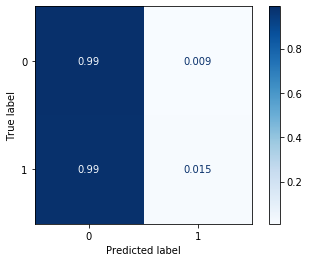

In [63]:
# Test the accurary of the model with a confusion matrix

model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True
                              )

classifier = model.fit(X_train, y_train)
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize = 'true')

In [65]:
# Confirm poor test results with a Roc score
predict_prop = model.predict_proba(X_test)
p_probs = predict_prop[:,1]
roc_auc_value = roc_auc_score(y_test, p_probs)
print(roc_auc_value)

0.549349849019245


## Conclusion

Looking at the confusion matrix and the roc_value it is clear that the model does not accurately predict clicks. The confusion matrix shows that 98.5% of the time the model predicts no clicks when it should have predicted a click, while the roc_auc_value shows that the model is close to a predictor that predicts zero in all cases.

This is not surprising. The data exploration analysis portion of this notebook shows that many of the features of the dataset make little impact on whether the user clicks the advertisement or not. For example, most of the catagories in each of the variables of the dataset only have their number of clicks grow in proportion to the fraction of the variable the individual catagory accounts for. This implies that many of the variables do not contain information that is valuable for prediction if a user will click on an advertisement as the information does not influence if an advertisement is clicked.

Other data should be used to enrish this dataset. Based on internet research useful data includes:

- device type
- location type - sports stadium, malls, residence ect.
- regions defined by wealth
- season 
- time of day

Another area of to explore to improve the model is using different dimensionality reducing techiques such as using clustering, lasso and support vectors.

As well, for future improvements other types of classifier models can be explored.

Although I believe that the bigger issue lies with the explanatory variables, perhaps and not the model type